In [13]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles/updated'
directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
#directories = []
total_size = 640
segment_to_skip = 100

torch.set_default_dtype(torch.float64)
# torch.set_printoptions(precision=10)

X_data_train = torch.empty(0, total_size - segment_to_skip, 9)
y_data_train = torch.empty(0, total_size - segment_to_skip, 3)
X_data_test = torch.empty(0, total_size - segment_to_skip, 9)
y_data_test = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Training_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Training_files/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'L', 'Lon', 'Lat', 'B', 'A/A0', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha', 'Lon', 'Lat', 'V/Cs', 'propag_dt']].values, dtype=torch.float64)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float64)
        
        X_data_train = torch.cat((X_data_train, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_train = torch.cat((y_data_train, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Validation_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Validation_files/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'L', 'Lon', 'Lat', 'B', 'A/A0', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha', 'Lon', 'Lat', 'V/Cs', 'propag_dt']].values, dtype=torch.float64)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float64)
        
        X_data_test = torch.cat((X_data_test, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_test = torch.cat((y_data_test, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

X_data_train = X_data_train.permute(0, 2, 1)
y_data_train = y_data_train.permute(0, 2, 1)

X_data_test = X_data_test.permute(0, 2, 1)
y_data_test = y_data_test.permute(0, 2, 1)

X_data_train.shape, y_data_train.shape

(torch.Size([10594, 9, 540]), torch.Size([10594, 3, 540]))

In [21]:
y_data_train[:, 2, :].max()

tensor(4.9130)

In [14]:
# save tensors to file
torch.save(X_data_train, 'X_data_train_raw.pt')
torch.save(y_data_train, 'y_data_train_raw.pt')
torch.save(X_data_test, 'X_data_test_raw.pt')
torch.save(y_data_test, 'y_data_test_raw.pt')

In [15]:
X_data_train.shape, y_data_train.shape

(torch.Size([10594, 9, 540]), torch.Size([10594, 3, 540]))

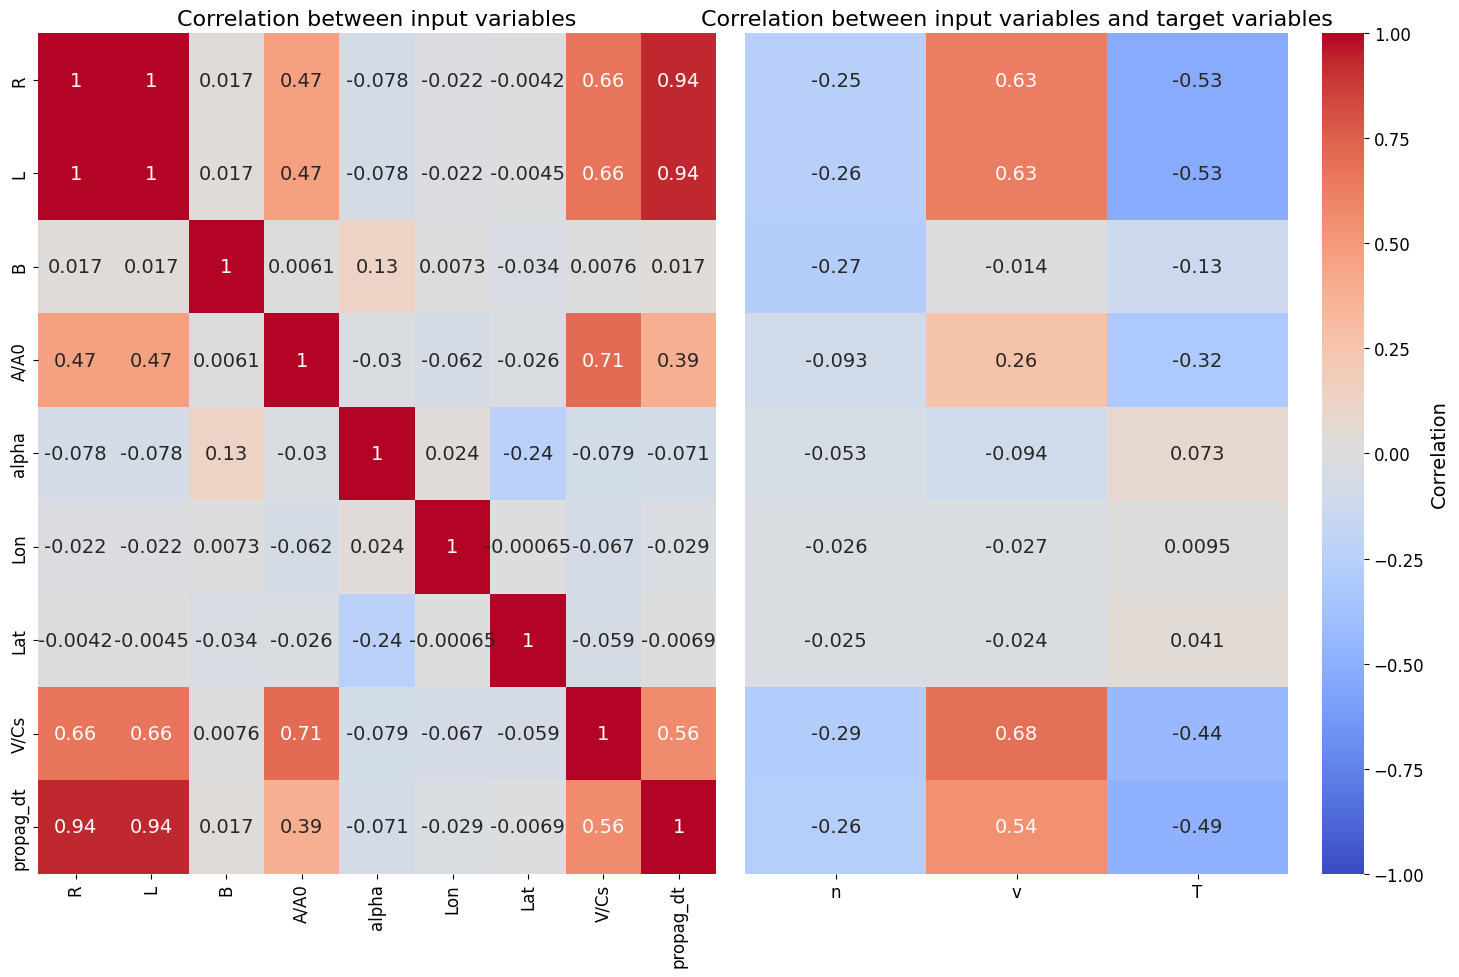

In [22]:
# do a correlation analysis between the features and the target variables
# and plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_data_train_ = X_data_train.permute(0, 2, 1).reshape(-1, 9)
y_data_train_ = y_data_train.permute(0, 2, 1).reshape(-1, 3)

X_data_train_.shape, y_data_train_.shape

X_data_train_df = pd.DataFrame(X_data_train_.numpy(), columns=['R', 'L', 'B', 'A/A0', 'alpha', 'Lon', 'Lat', 'V/Cs', 'propag_dt'])
y_data_train_df = pd.DataFrame(y_data_train_.numpy(), columns=['n', 'v', 'T'])

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

# corr is a dataframe with the correlation values between the features and the target variables
corr = pd.DataFrame()
corr['n'] = X_data_train_df.corrwith(y_data_train_df['n'])
corr['v'] = X_data_train_df.corrwith(y_data_train_df['v'])
corr['T'] = X_data_train_df.corrwith(y_data_train_df['T'])

corr_inputs = X_data_train_df.corr()
# plot  and save the correlation matrices, side by side, with the same scale
# only show the scale on the right side and dont show the input variable names on the right plot
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(corr_inputs, ax=ax[0], annot=True, cmap='coolwarm', cbar=False, vmin=-1, vmax=1)
sns.heatmap(corr, ax=ax[1], annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1, yticklabels=False)
ax[0].set_title('Correlation between input variables')
ax[1].set_title('Correlation between inputs and targets')
plt.tight_layout()
plt.savefig('correlation_analysis.png')
plt.show()


In [9]:
# drop Lon, Lat, V/Cs, propag_dt from the input data
X_data_train = X_data_train[:, :5, :]
X_data_test = X_data_test[:, :5, :]
X_data_train.shape, X_data_test.shape

(torch.Size([10594, 5, 540]), torch.Size([1177, 5, 540]))

In [40]:
# save tensors to file
torch.save(X_data_train, 'X_data_train_raw.pt')
torch.save(y_data_train, 'y_data_train_raw.pt')
torch.save(X_data_test, 'X_data_test_raw.pt')
torch.save(y_data_test, 'y_data_test_raw.pt')

In [3]:
# load tensors from file
X_data = torch.load('X_data_train_raw.pt')
y_data = torch.load('y_data_train_raw.pt')

In [96]:
X_data_train.shape, y_data_train.shape

(torch.Size([10594, 5, 540]), torch.Size([10594, 3, 540]))

In [44]:
DX_UN  =   6.96000e+10  # length unit factor (to cm)
VX_UN  =   1e+05 # speed unit factor (to cm/s)
TE_UN  =   1.00000e+06  # temperature unit factor (to K)
NE_UN  =   1.00000e+17  # density unit factor (to 1/cm^3)
DT_UN  =       5413.93  # time unit factor (to s)

NU_UN = (DX_UN**2)/DT_UN   # viscosity coeff init factor (to cm^2/s)

NU_VISC = .1 * NU_UN    # the actual viscosity coeff

In [103]:
# apply fft to the data
import torch.fft

fft_y_train_n = torch.fft.fft(y_data[:, 0, :], dim=1)
fft_y_train_n

tensor([[5.2939e+09+0.0000e+00j, 3.2257e+09-2.9095e+09j, 9.5053e+08-2.4638e+09j,
          ..., 4.5703e+08+1.5710e+09j, 9.5053e+08+2.4638e+09j,
         3.2257e+09+2.9095e+09j],
        [4.9975e+09+0.0000e+00j, 3.0686e+09-2.7331e+09j, 9.2703e+08-2.3413e+09j,
          ..., 4.4009e+08+1.5029e+09j, 9.2703e+08+2.3413e+09j,
         3.0686e+09+2.7331e+09j],
        [4.9960e+09+0.0000e+00j, 3.0893e+09-2.7228e+09j, 9.4772e+08-2.3557e+09j,
          ..., 4.4462e+08+1.5158e+09j, 9.4772e+08+2.3557e+09j,
         3.0893e+09+2.7228e+09j],
        ...,
        [3.2034e+09+0.0000e+00j, 1.7500e+09-1.7624e+09j, 5.5352e+08-1.3009e+09j,
          ..., 3.3144e+08+9.2253e+08j, 5.5352e+08+1.3009e+09j,
         1.7500e+09+1.7624e+09j],
        [3.1613e+09+0.0000e+00j, 1.7286e+09-1.7380e+09j, 5.4888e+08-1.2837e+09j,
          ..., 3.2949e+08+9.1257e+08j, 5.4888e+08+1.2837e+09j,
         1.7286e+09+1.7380e+09j],
        [3.2348e+09+0.0000e+00j, 1.7640e+09-1.7805e+09j, 5.5730e+08-1.3116e+09j,
          ..., 3

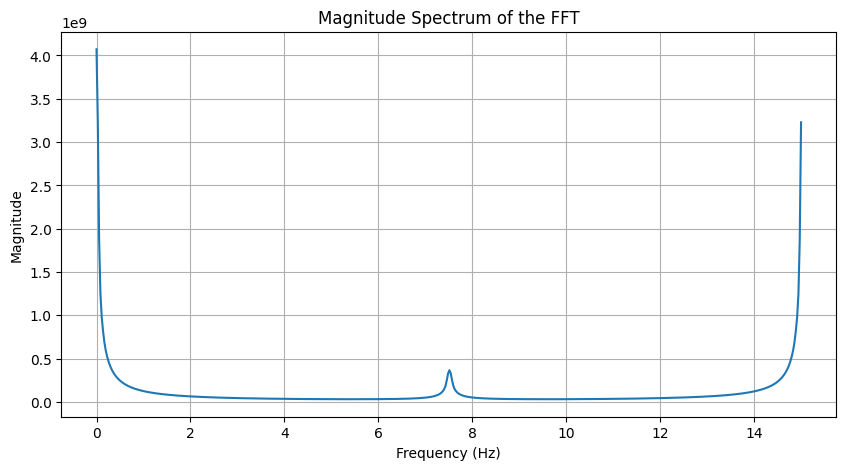

In [104]:
import numpy as np

magnitude_spectrum = torch.abs(fft_y_train_n).numpy()  # Convert to numpy array for easier handling

# Frequency axis preparation
# Let's say your data was sampled at fs samples per second
fs = 30  # replace with your actual sampling rate
freq = np.linspace(0, fs / 2, magnitude_spectrum.shape[1])  # Frequency axis up to Nyquist frequency

# Average the magnitude spectrum if there are multiple samples for clarity
average_magnitude = np.mean(magnitude_spectrum, axis=0)

# Plotting the magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(freq, average_magnitude)
plt.title('Magnitude Spectrum of the FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# This plot helps you decide on the cutoff frequency. Look for the frequency beyond which the signal magnitude drops significantly or becomes noisy.

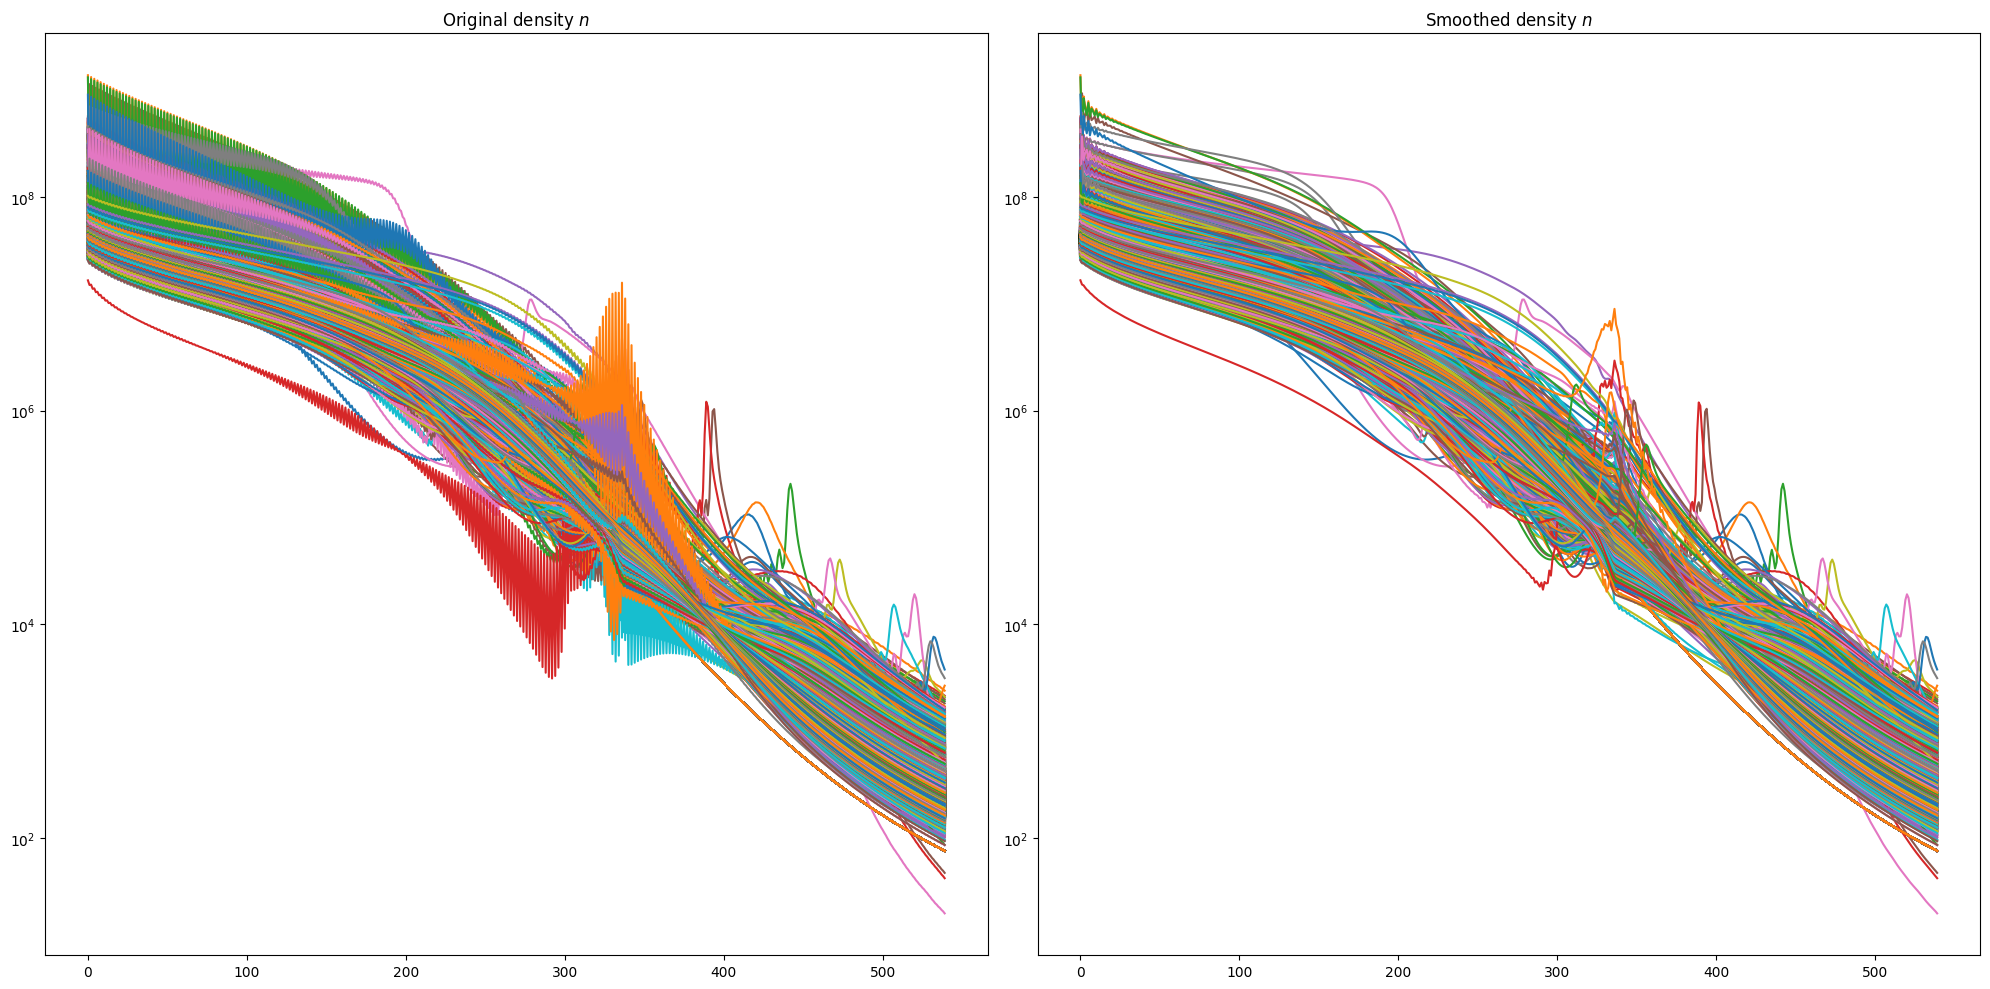

In [106]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Butterworth Low-pass Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    data_ = data.clone()
    
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data_)
    return y

# make a side by side plot of plt.semilogy(y_data[:, 0, :].T)
# with the left side being just that, and the right side is y_data after applying butterworth filter

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].semilogy(y_data[:, 0, :].T)
ax[0].set_title('Original density $n$')
ax[1].semilogy(butter_lowpass_filter(y_data[:, 0, :],  12, 30, 6).T)
ax[1].set_title('Smoothed density $n$')
plt.tight_layout()
plt.savefig('smoothed-n.png')
plt.show()

In [97]:
# outlier 
# get indices of samples where A/A0 is smaller than 0
outlier = (X_data[:, 3, :] < -50000).sum(dim=1)

outlier = outlier.nonzero().squeeze()
outlier

tensor(3438)

In [100]:
# outlier 
# get indices of samples where A/A0 is smaller than 0
val = butter_lowpass_filter(y_data[:, 0, :],  12, 30, 6)
outlier = torch.Tensor(val < -50000).sum(dim=1)

outlier = outlier.nonzero().squeeze()
outlier

tensor(3051)

In [101]:
# remove outlier
X_data = torch.cat((X_data[:outlier], X_data[outlier+1:]), dim=0)
y_data = torch.cat((y_data[:outlier], y_data[outlier+1:]), dim=0)

In [102]:
# get indices of samples where A/A0 is smaller than 0
indices = (X_data[:, 3, :] < 0).sum(dim=1)

non_zero_indices = indices.nonzero().squeeze()
non_zero_indices

tensor([ 280,  491,  840,  906, 1057, 1368, 1456, 1475, 1608, 1773, 3245, 3330,
        3334, 3457, 3458, 3488, 3580, 3603, 3622, 3629, 3653, 4856, 5016, 5065,
        5070, 5350, 5351, 5353, 5356, 5363, 5365, 5367, 5660, 6820, 6971, 7481,
        8111])

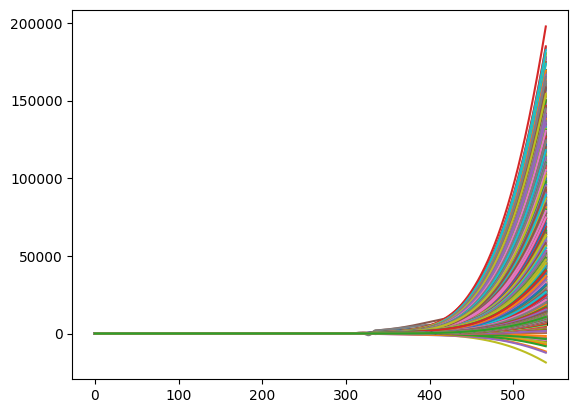

In [52]:
import matplotlib.pyplot as plt

plt.plot(X_data[:, 3, :].T)
plt.show()

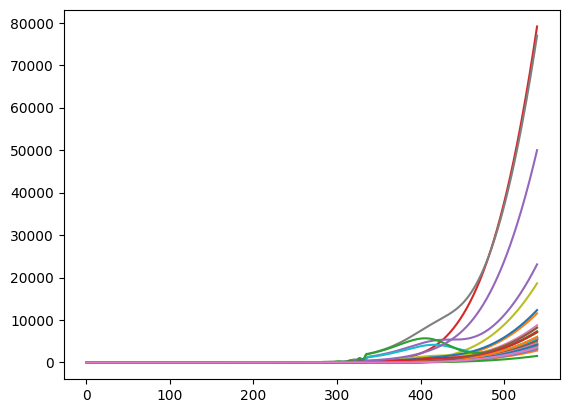

In [198]:
import matplotlib.pyplot as plt

plt.plot(torch.abs(X_data[non_zero_indices, 3, :]).T)
plt.show()

In [10]:
# save tensors to file
torch.save(X_data, 'X_data_train.pt')
torch.save(y_data, 'y_data_train.pt')

In [211]:
X_data[:, 2, :] = torch.abs(X_data[:, 2, :])
X_data[:, 3, :] = torch.abs(X_data[:, 3, :])

# Analysis for Inputs

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the statistical measures for each variable
stats = {
    'Variable': [],
    'Mean': [],
    'Median': [],
    'Std': [],
    'Skewness': [],
    'Kurtosis': []
}

# Calculate statistics for each variable
for i in range(5):
    variable_data = X_data[:, i, :].numpy().flatten()  # Flatten to treat all points equally
    stats['Variable'].append(f'Variable {i+1}')
    stats['Mean'].append(np.mean(variable_data))
    stats['Median'].append(np.median(variable_data))
    stats['Std'].append(np.std(variable_data))
    stats['Skewness'].append(skew(variable_data))
    stats['Kurtosis'].append(kurtosis(variable_data))

# Convert stats dictionary to a DataFrame for easier viewing
stats_df = pd.DataFrame(stats)

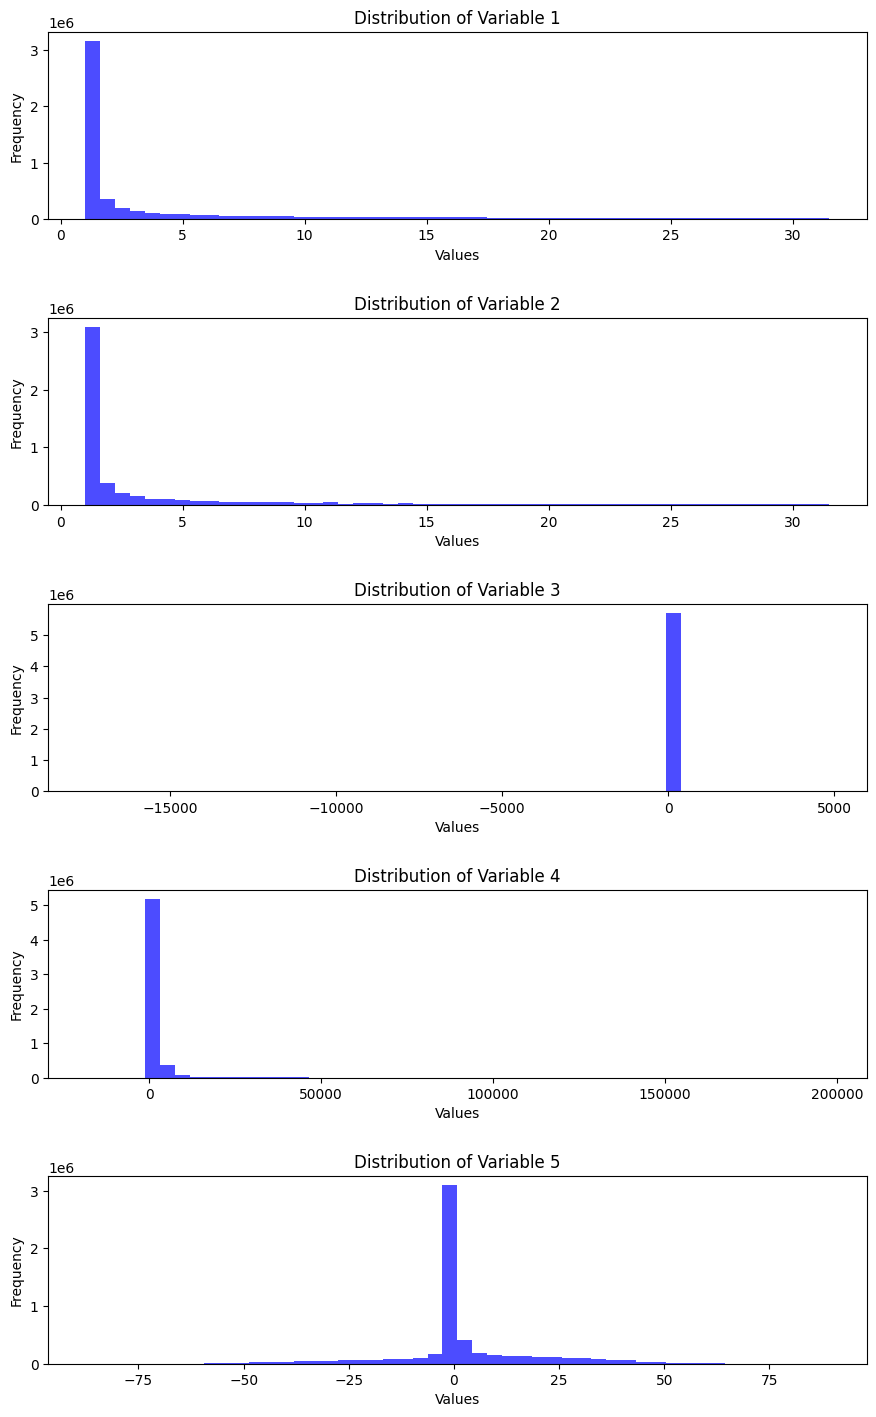

(     Variable         Mean    Median          Std    Skewness       Kurtosis
 0  Variable 1     5.450089  1.363965     7.599890    1.872413       2.404290
 1  Variable 2     5.518898  1.411528     7.642969    1.860661       2.363347
 2  Variable 3    -0.390489  0.000742    13.612508 -368.562153  485074.581785
 3  Variable 4  1254.359802  5.934591  5898.123326   11.951509     191.147339
 4  Variable 5     2.266041  0.000000    15.987142    0.139726       2.993707,
 None)

In [200]:
# Plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(5):
    axs[i].hist(X_data[:, i, :].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'Distribution of Variable {i+1}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Values')

stats_df, plt.show()  # Display statistics and plots

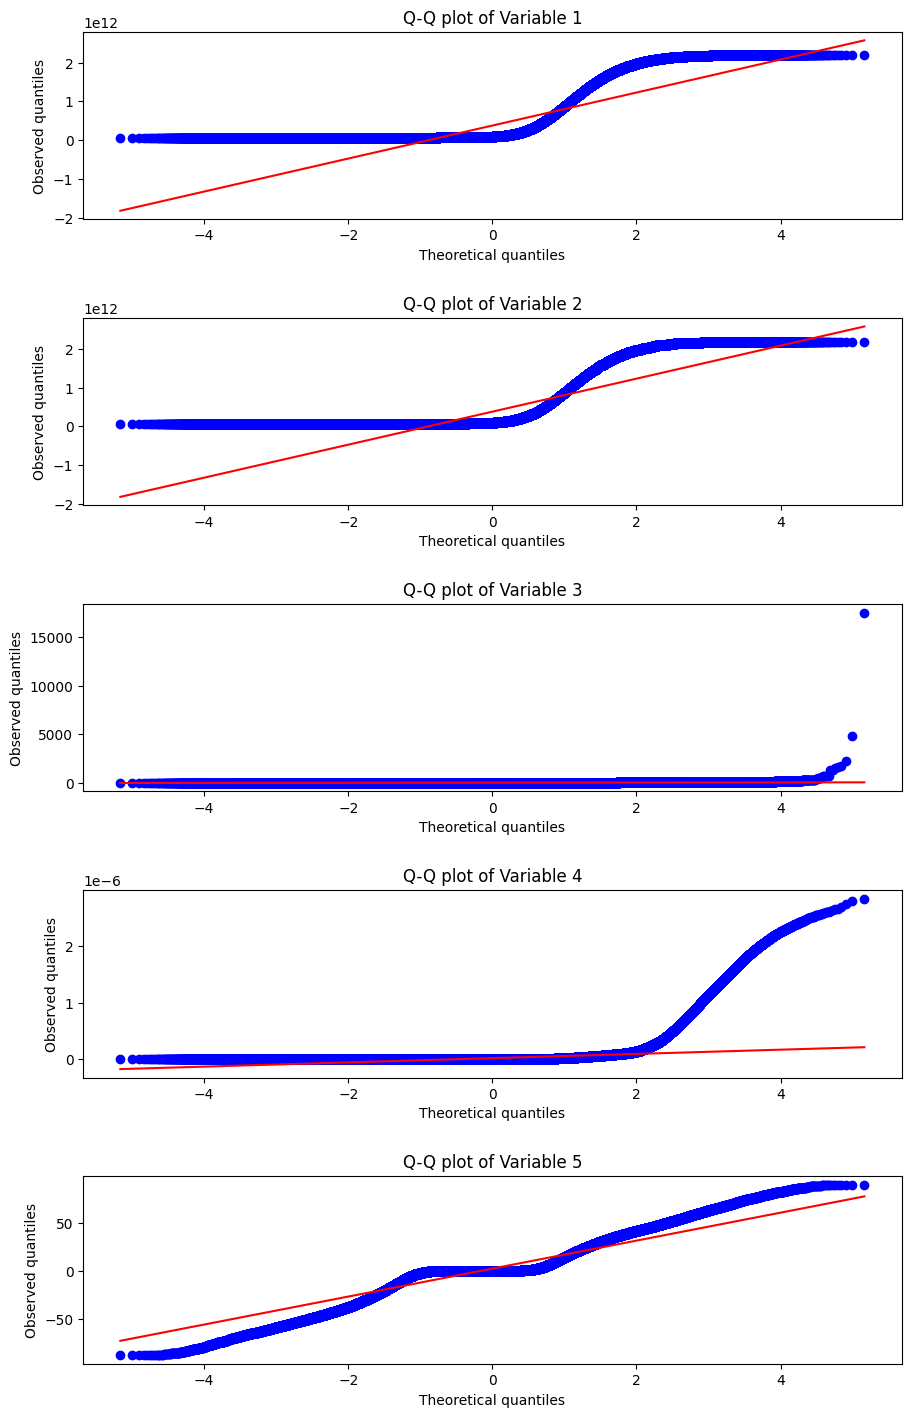

In [62]:
# qq plots
import scipy.stats as stats
import numpy as np

fig, axs = plt.subplots(5, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(5):
    stats.probplot(X_data[:, i, :].numpy().flatten(), dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q plot of Variable {i+1}')
    axs[i].set_xlabel('Theoretical quantiles')
    axs[i].set_ylabel('Observed quantiles')

In [212]:
import torch
from sklearn.preprocessing import RobustScaler
import numpy as np

class TensorRobustScaler:
    def __init__(self):
        self.median = None
        self.iqr = None
        
    def fit(self, X):
        self.median = torch.quantile(X, 0.5, dim=-1, keepdim=True)
        q1 = torch.quantile(X, 0.25, dim=-1, keepdim=True)
        q3 = torch.quantile(X, 0.75, dim=-1, keepdim=True)
        self.iqr = q3 - q1
        
    def transform(self, X):
        return (X - self.median) / self.iqr
    
    def inverse_transform(self, X):
        return (X * self.iqr) + self.median

def get_normalization_info_inputs(X):
    X_normalized = X.clone()
    normalization_info = {}
    
    for var in [0, 1]:
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        mean = X_var_transformed.mean()
        std = X_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
    
    for var in [2]:
        tensor_robust_scaler = TensorRobustScaler()
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        tensor_robust_scaler.fit(X_var_transformed)
        normalization_info[var] = {"scaler": tensor_robust_scaler, "method": "log_robust_scaling"}
    
    for var in [3]:
        tensor_robust_scaler = TensorRobustScaler()
        X_var = X_normalized[:, var, :]
        tensor_robust_scaler.fit(X_var)
        normalization_info[var] = {"scaler": tensor_robust_scaler, "method": "robust_scaling"}
    
    for var in [4]:
        X_var = X_normalized[:, var, :]
        mean = X_var.mean()
        std = X_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
        
    return normalization_info

def normalize(X, normalization_info):
    X_normalized = X.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (X_normalized[:, var, :] - mean) / std
        elif info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (torch.log1p(X_normalized[:, var, :]) - mean) / std
        elif info["method"] == "robust_scaling":
            scaler = info["scaler"]
            X_normalized[:, var, :] = scaler.transform(X_normalized[:, var, :])
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_normalized[:, var, :] = scaler.transform(torch.log1p(X_normalized[:, var, :]))
    
    return X_normalized

def denormalize(X_normalized, normalization_info):
    X_denormalized = X_normalized.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = (X_denormalized[:, var, :] * std) + mean
        elif info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = torch.expm1((X_denormalized[:, var, :] * std) + mean)
        elif info["method"] == "robust_scaling":
            scaler = info["scaler"]
            X_denormalized[:, var, :] = scaler.inverse_transform(X_denormalized[:, var, :])
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_denormalized[:, var, :] = torch.expm1(scaler.inverse_transform(X_denormalized[:, var, :]))
    
    return X_denormalized

In [204]:
# get negative values of y
negative = (filtered_y[:, 0, :] < 0).sum(dim=1) + (filtered_y[:, 1, :] < 0).sum(dim=1)
negative_indices = negative.nonzero().squeeze()
negative_indices

tensor([3051, 5294, 6797, 6863, 6891, 6892, 6926, 7004, 9184, 9236, 9493, 9556,
        9622, 9623, 9692])

In [205]:
def th_delete(tensor, indices):
    mask = torch.ones(tensor.shape[0], dtype=torch.bool)
    mask[indices] = False
    return tensor[mask, :, :]

filtered_x = th_delete(filtered_x, negative_indices)
filtered_y = th_delete(filtered_y, negative_indices)

In [213]:
normalization_info_inputs = get_normalization_info_inputs(X_data)
X_data_normalized = normalize(X_data, normalization_info_inputs)

In [214]:
normalization_info_inputs

{0: {'mean': tensor(1.3850),
  'std': tensor(0.8841),
  'method': 'log_standardization'},
 1: {'mean': tensor(1.3967),
  'std': tensor(0.8855),
  'method': 'log_standardization'},
 2: {'scaler': <__main__.TensorRobustScaler at 0x1adc7d1b350>,
  'method': 'log_robust_scaling'},
 3: {'scaler': <__main__.TensorRobustScaler at 0x1adbedc0110>,
  'method': 'robust_scaling'},
 4: {'mean': tensor(2.2587),
  'std': tensor(15.9874),
  'method': 'standardization'}}

In [215]:
X_data_normalized[0, :, :]

tensor([[-7.7621e-01, -7.7613e-01, -7.7606e-01,  ...,  2.3497e+00,
          2.3590e+00,  2.3683e+00],
        [-7.8817e-01, -7.8810e-01, -7.8802e-01,  ...,  2.3356e+00,
          2.3448e+00,  2.3540e+00],
        [ 7.6591e-01,  7.6574e-01,  7.6558e-01,  ..., -3.2016e-01,
         -3.2017e-01, -3.2017e-01],
        [-1.6488e-02, -1.6487e-02, -1.6487e-02,  ...,  2.3131e+01,
          2.3453e+01,  2.3748e+01],
        [-1.4763e-01, -1.4742e-01, -1.4721e-01,  ..., -1.4128e-01,
         -1.4128e-01, -1.4128e-01]])

In [216]:
X_data_denormalized = denormalize(X_data_normalized, normalization_info_inputs)

In [217]:
(X_data[:, :, :] - X_data_denormalized[:, :, :]).abs().sum()

tensor(1.0658e-07)

# Analysis for Outputs

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the statistical measures for each variable
stats = {
    'Variable': [],
    'Mean': [],
    'Median': [],
    'Std': [],
    'Skewness': [],
    'Kurtosis': []
}

# Calculate statistics for each variable
for i in range(3):
    variable_data = y_data[:, i, :].numpy().flatten()  # Flatten to treat all points equally
    stats['Variable'].append(f'Variable {i+1}')
    stats['Mean'].append(np.mean(variable_data))
    stats['Median'].append(np.median(variable_data))
    stats['Std'].append(np.std(variable_data))
    stats['Skewness'].append(skew(variable_data))
    stats['Kurtosis'].append(kurtosis(variable_data))

# Convert stats dictionary to a DataFrame for easier viewing
stats_df = pd.DataFrame(stats)

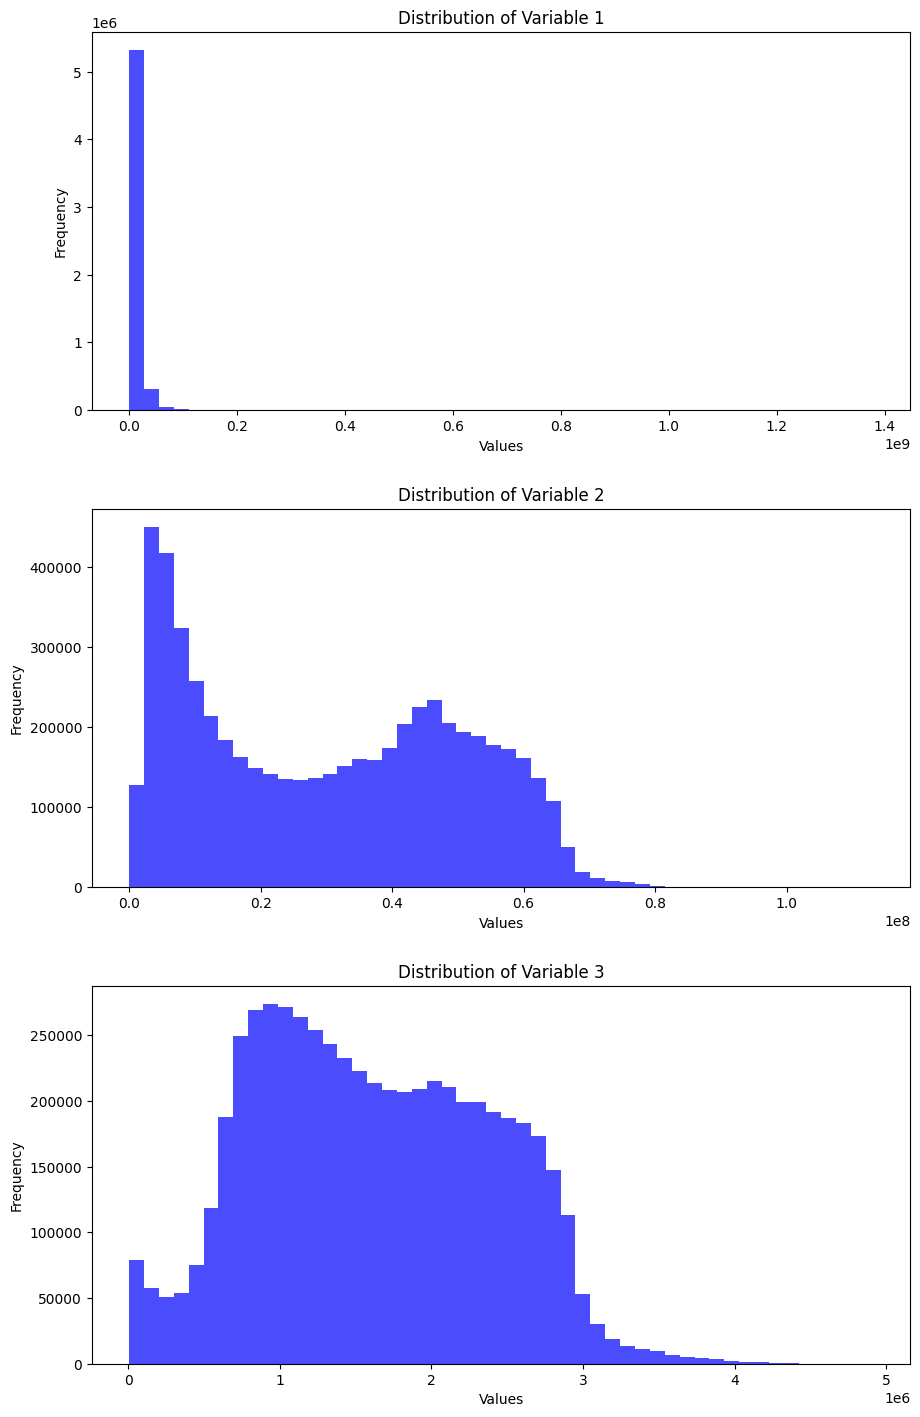

(     Variable          Mean        Median           Std  Skewness    Kurtosis
 0  Variable 1  7.539610e+06  6.473431e+05  1.726924e+07  9.664854  235.077234
 1  Variable 2  3.013274e+07  2.988103e+07  2.024155e+07  0.155911   -1.313253
 2  Variable 3  1.613033e+06  1.557080e+06  7.694372e+05  0.171579   -0.703927,
 None)

In [69]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(3):
    axs[i].hist(y_data[:, i, :].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'Distribution of Variable {i+1}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Values')

stats_df, plt.show()  # Display statistics and plots

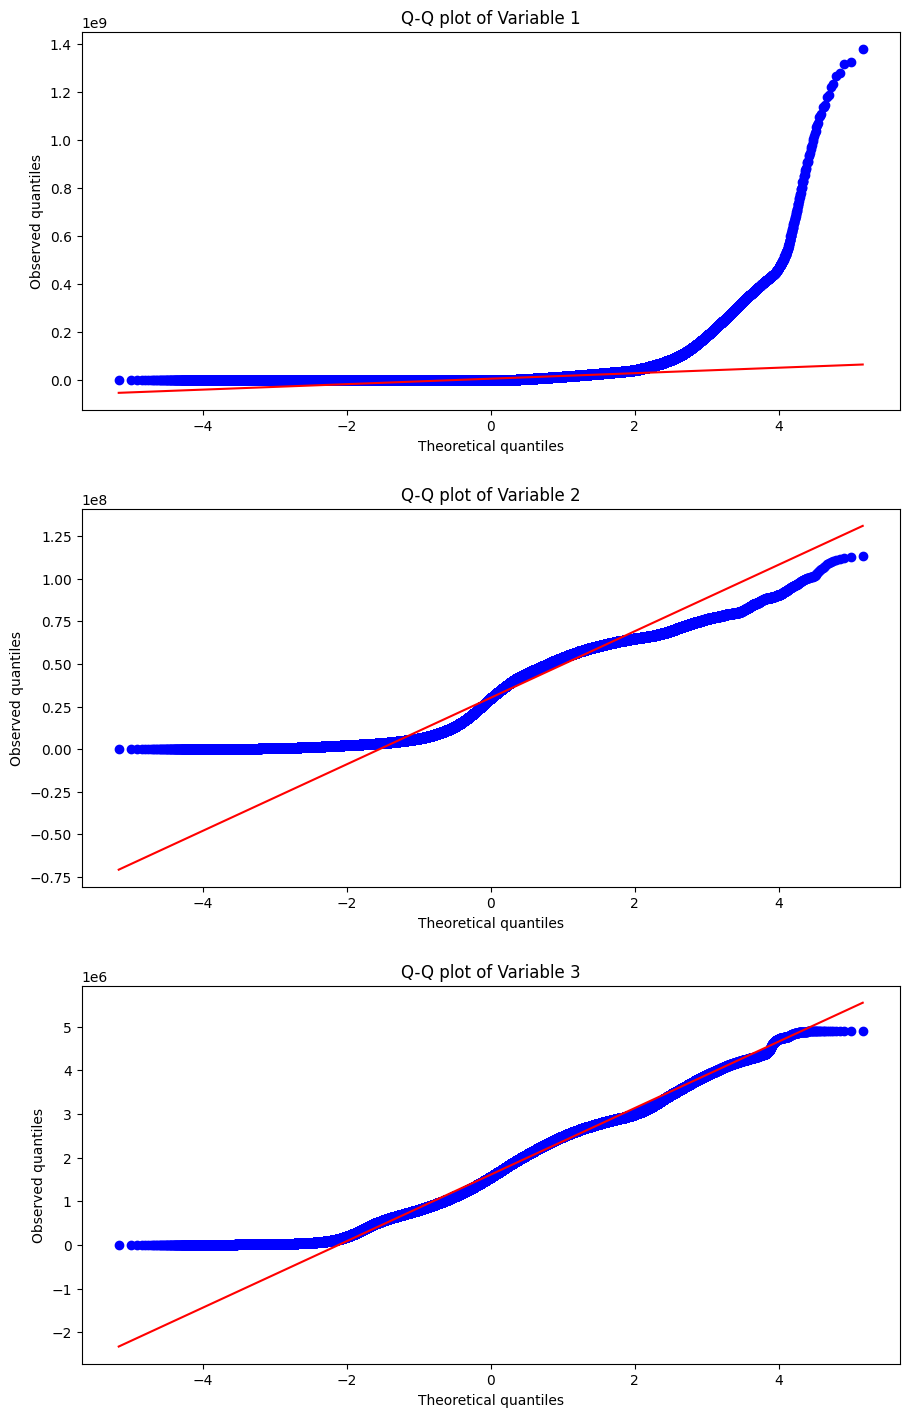

In [70]:
# qq plots
import scipy.stats as stats
import numpy as np

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(3):
    stats.probplot(y_data[:, i, :].numpy().flatten(), dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q plot of Variable {i+1}')
    axs[i].set_xlabel('Theoretical quantiles')
    axs[i].set_ylabel('Observed quantiles')

In [218]:
def get_normalization_info_outputs(y):
    y_normalized = y.clone()
    normalization_info = {}
    
    for var in [0]:
        y_var = y_normalized[:, var, :]
        y_var_transformed = torch.log1p(y_var)
        mean = y_var_transformed.mean()
        std = y_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
        
    for var in [1, 2]:
        y_var = y_normalized[:, var, :]
        mean = y_var.mean()
        std = y_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
    
    return normalization_info

In [219]:
normalization_info_outputs = get_normalization_info_outputs(y_data)
y_data_normalized = normalize(y_data, normalization_info_outputs)

In [220]:
normalization_info_outputs

{0: {'mean': tensor(12.4887),
  'std': tensor(3.8747),
  'method': 'log_standardization'},
 1: {'mean': tensor(301.4900),
  'std': tensor(202.4058),
  'method': 'standardization'},
 2: {'mean': tensor(1.6135),
  'std': tensor(0.7691),
  'method': 'standardization'}}

In [221]:
y_data_normalized[0, :, :]

tensor([[ 1.4427,  1.4370,  1.4311,  ..., -1.7306, -1.7347, -1.7385],
        [-1.2208, -1.2165, -1.2122,  ...,  1.5598,  1.5604,  1.5610],
        [-0.6129, -0.5938, -0.5748,  ..., -1.6996, -1.7033, -1.7067]])

In [222]:
# get indices of y_data where n is negative
indices = (y_data[:, 0, :] < 0).sum(dim=1).nonzero().squeeze()

indices

tensor([], dtype=torch.int64)

In [223]:
y_denormalized = denormalize(y_data_normalized, normalization_info_outputs)

In [224]:
y_denormalized[0, :, :] == y_data[0, :, :]

tensor([[False, False, False,  ..., False, False,  True],
        [ True, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ..., False, False, False]])

In [225]:
(y_denormalized[:, :, :] - y_data[:, :, :]).abs().sum()

tensor(0.0358)

# Smoothing

In [74]:
# apply fft to the data
import torch.fft

X_b = torch.fft.fft(X_data[:, 2, :], dim=-1)
X_a_a0 = torch.fft.fft(X_data[:, 3, :], dim=-1)

In [76]:
X_b[0].shape, X_a_a0[0].shape

(torch.Size([540]), torch.Size([540]))

In [202]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np

# Butterworth Low-pass Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    data_ = data.clone()
    
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data_)
    return y

# Apply the filter
filtered_x = X_data.clone()
#filtered_y = y_data.clone()


filtered_x[:, 2, :] = torch.Tensor(butter_lowpass_filter(X_data[:, 2, :], 3.667, 100, 6).copy())
filtered_x[:, 3, :] = torch.Tensor(butter_lowpass_filter(X_data[:, 3, :], 3.667, 100, 6).copy())
filtered_y = torch.Tensor(butter_lowpass_filter(y_data, 3.667, 100, 6).copy())

Text(0, 0.5, 'Amplitude')

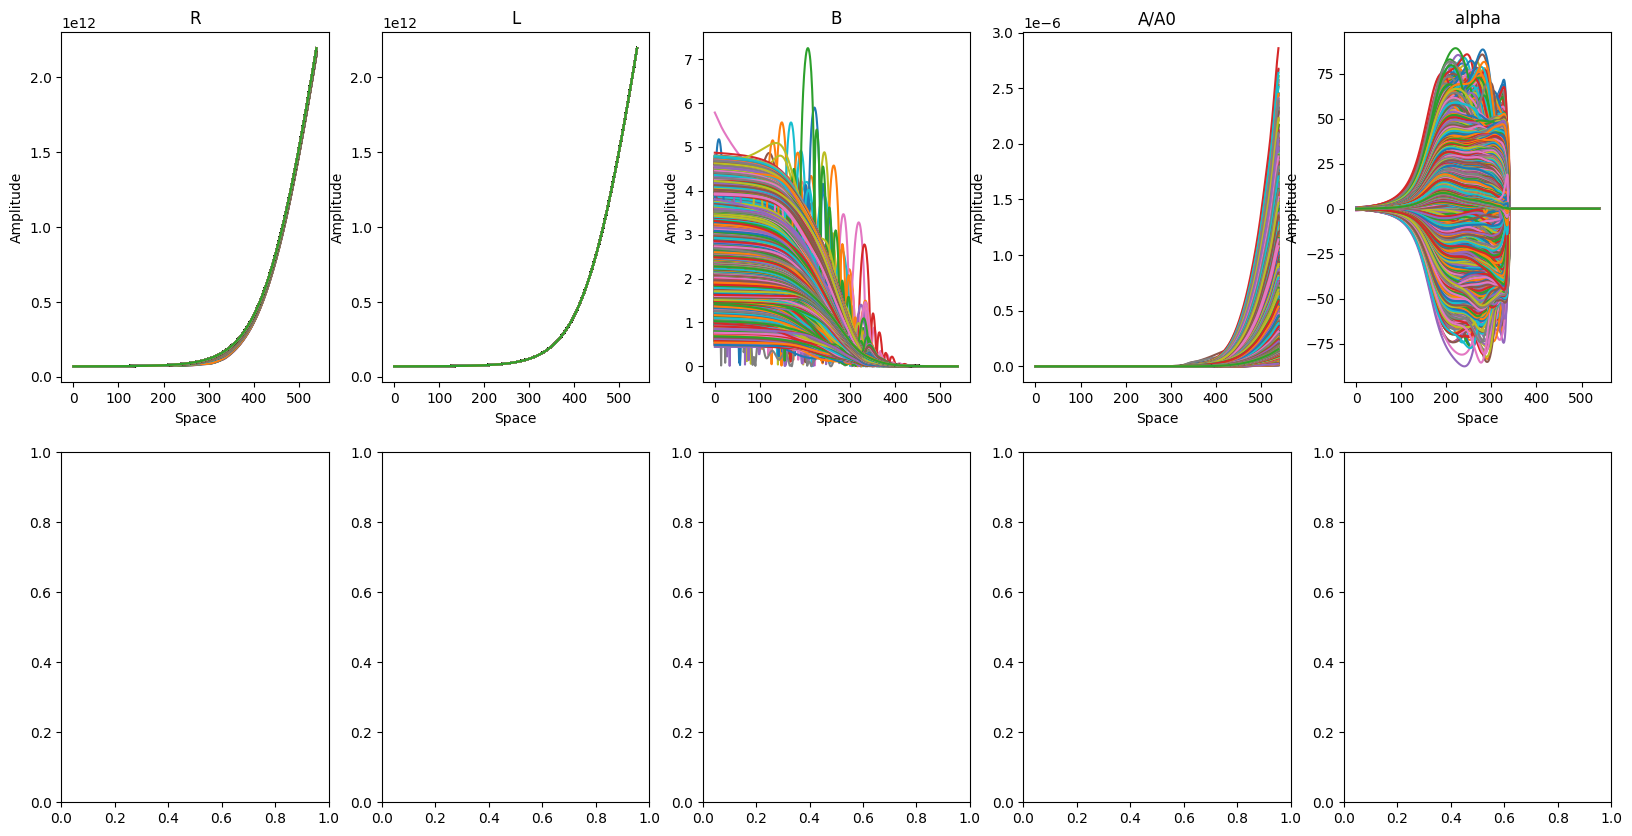

In [86]:
# show inputs

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

axs[0, 0].plot(filtered_x[:, 0, :].T)
axs[0, 0].set_title('R')
axs[0, 0].set_xlabel('Space')
axs[0, 0].set_ylabel('Amplitude')

axs[0, 1].plot(filtered_x[:, 1, :].T)
axs[0, 1].set_title('L')
axs[0, 1].set_xlabel('Space')
axs[0, 1].set_ylabel('Amplitude')

axs[0, 2].plot(np.log1p(abs(filtered_x[:, 2, :])).T)
axs[0, 2].set_title('B')
axs[0, 2].set_xlabel('Space')
axs[0, 2].set_ylabel('Amplitude')

axs[0, 3].plot(np.log1p(abs(filtered_x[:, 3, :])).T)
axs[0, 3].set_title('A/A0')
axs[0, 3].set_xlabel('Space')
axs[0, 3].set_ylabel('Amplitude')

axs[0, 4].plot(filtered_x[:, 4, :].T)
axs[0, 4].set_title('alpha')
axs[0, 4].set_xlabel('Space')
axs[0, 4].set_ylabel('Amplitude')

In [ ]:
# show outputs
fig, axs = plt.subplots(2, 3, figsize=(10, 15))

axs[0, 0].plot(y_data[:, 0, :].T)
axs[0, 0].set_title('n')
axs[0, 0].set_xlabel('Space')
axs[0, 0].set_ylabel('Amplitude')

axs[0, 1].plot(y_data[:, 1, :].T)
axs[0, 1].set_title('v')
axs[0, 1].set_xlabel('Space')
axs[0, 1].set_ylabel('Amplitude')

axs[0, 2].plot(y_data[:, 2, :].T)
axs[0, 2].set_title('T')
axs[0, 2].set_xlabel('Space')
axs[0, 2].set_ylabel('Amplitude')

axs[1, 0].plot(filtered_y[:, 0, :].T)
axs[1, 0].set_title('n')
axs[1, 0].set_xlabel('Space')
axs[1, 0].set_ylabel('Amplitude')

axs[1, 1].plot(filtered_y[:, 1, :].T)
axs[1, 1].set_title('v')
axs[1, 1].set_xlabel('Space')
axs[1, 1].set_ylabel('Amplitude')

axs[1, 2].plot(filtered_y[:, 2, :].T)
axs[1, 2].set_title('T')
axs[1, 2].set_xlabel('Space')
axs[1, 2].set_ylabel('Amplitude')

In [206]:
filtered_x.shape, filtered_y.shape

(torch.Size([10578, 5, 540]), torch.Size([10578, 3, 540]))

In [207]:
# save filtered x and y
torch.save(torch.Tensor(filtered_x), 'X_data_train.pt')
torch.save(torch.Tensor(filtered_y), 'y_data_train.pt')